# How long are birdcall recordings

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [21]:
from pyspark.sql import SparkSession, functions as F
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
spark = SparkSession.builder.getOrCreate()
spark

In [14]:
df = (
    spark.read.csv("../data/raw/birdclef-2022/train_metadata.csv", header=True)
    .repartition(8)
    .cache()
)
df.printSchema()
df.show(vertical=True, n=1, truncate=False)

root
 |-- primary_label: string (nullable = true)
 |-- secondary_labels: string (nullable = true)
 |-- type: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- scientific_name: string (nullable = true)
 |-- common_name: string (nullable = true)
 |-- author: string (nullable = true)
 |-- license: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- time: string (nullable = true)
 |-- url: string (nullable = true)
 |-- filename: string (nullable = true)

-RECORD 0---------------------------------------------------------------------
 primary_label    | houfin                                                    
 secondary_labels | []                                                        
 type             | ['song']                                                  
 latitude         | 19.392                                                    
 longitude        | -99.241                                              

In [81]:
df.count()

14852

In [46]:
(
    df.select("time")
    .where("length(time) < 3 or time like '%?%' or time like '%:%:%'")
    .groupBy("time")
    .count()
    .show()
)

+--------+-----+
|    time|count|
+--------+-----+
|       x|    7|
|   ??:??|    1|
|       .|   13|
|19:18:57|    1|
|     ?:?|   51|
|      am|    9|
|       ?|  487|
|08:53:50|    1|
|07:57:21|    1|
|07:46:52|    1|
|      pm|    1|
|04:31:10|    1|
|07:57:28|    1|
|11:23:40|    1|
|20:51:07|    1|
|02:10:41|    1|
|13:13:37|    1|
|07:55:40|    1|
|07:18:57|    1|
|08:41:55|    1|
+--------+-----+
only showing top 20 rows



In [58]:
import re


@F.udf(returnType="int")
def time_to_seconds(time):
    # this could be done in pure sql too, fwiw
    if not time or re.search(r"[^0-9:]", time):
        return -1
    try:
        minute, sec = time.split(":")
        hour = "0"
    except:
        hour, minute, sec = time.split(":")
    return (
        int(hour.lstrip("0") or "0")
        + int(minute.lstrip("0") or "0") * 60
        + int(sec.lstrip("0") or "0")
    )


times = df.select("primary_label", time_to_seconds("time").alias("duration"))
times.show()

+-------------+--------+
|primary_label|duration|
+-------------+--------+
|       houfin|     420|
|       wesmea|     989|
|       norcar|     500|
|       normoc|     570|
|       skylar|    1110|
|       calqua|     711|
|       bcnher|     241|
|       gnwtea|    1200|
|       skylar|     686|
|       zebdov|    1031|
|       commyn|     390|
|       rorpar|     510|
|      comgal1|     975|
|       skylar|    1110|
|        brant|     338|
|       norsho|    1320|
|       comwax|     778|
|       rorpar|    1110|
|       glwgul|     450|
|       redjun|     930|
+-------------+--------+
only showing top 20 rows



In [59]:
pdf = times.toPandas()

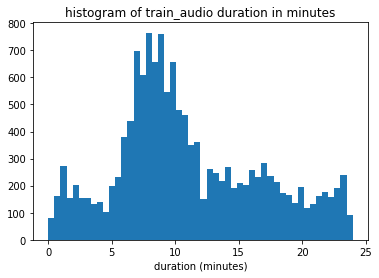

In [80]:
import matplotlib.pyplot as plt

plt.hist(pdf[(pdf.duration / 60 < 30) & (pdf.duration > 0)].duration / 60, bins=50)
plt.title("histogram of train_audio duration in minutes")
plt.xlabel("duration (minutes)")
plt.show()

## some stats about the motif dataset

In [3]:
!ls ../data/intermediate/

2022-02-21-motif


In [4]:
from pathlib import Path
import json
from tqdm.auto import tqdm

data = [
    json.loads(p.read_text())
    for p in tqdm(
        Path("../data/intermediate/2022-02-21-motif").glob("**/metadata.json")
    )
]

13856it [00:04, 3241.33it/s]


In [8]:
df = spark.createDataFrame(data)
df.show(vertical=True, n=2, truncate=80)

-RECORD 0-------------------------------------------------
 cens_sample_rate      | 10                               
 duration_cens         | 113                              
 duration_samples      | 244800                           
 duration_seconds      | 11.1                             
 matrix_profile_window | 50                               
 motif_0               | 61                               
 motif_1               | 26                               
 sample_rate           | 22050                            
 source_name           | train_audio/afrsil1/XC125458.ogg 
-RECORD 1-------------------------------------------------
 cens_sample_rate      | 10                               
 duration_cens         | 477                              
 duration_samples      | 1036800                          
 duration_seconds      | 47.02                            
 matrix_profile_window | 50                               
 motif_0               | 229                            

In [11]:
df.count()

13856

In [10]:
df.where("motif_0 = motif_1").count()

1202